In [10]:
### Load in necessary packages first
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [4]:
set.seed(1000) # Run this cell for reproducible results, DO NOT DELETE

# Project Planning Report

## Data Description

In this project I will be working with mainly the players.csv dataset. Below I have started introductory exploration of the dataset by reading it into the notebook, and having a quick preview of what it looks like in R.

In [5]:
playerdata <- read_csv("data/players.csv")
playerdata

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In the player.csv dataset there are 196 observations (rows) and 7 variables. The variables are as follows:
1. experience
    - Character variable with 5 different categories: Pro, Veteran, Amateur, Regular, Beginner

2. subscribe
    - Logical type variable denoting if a player is subscribed to game related newsletter
    
3. hashedEmail
    - Character variable that gives a player's hashed email address
    
4. played_hours
    - Double variable (integers with decimals) that reports how many hours played on the server by a player
    
5. name
    - Character variable giving a player's real name
    
6. gender
    - Character variable that gives the gender reported by a player
    
7. age
    - Double variable that gives the age reported by a player

Majority of the data was **collected** from players self reporting when initially signing up for the server except for played_hours which was collected via the server recording play sessions of the players.

### Issues
One issue with the data lies in the fact that a majority of it is self reported. The experience variable is based on how players evaluate themselves, and thus each player will have a different criteria for evaluating their own experience level. It does not tell us anything about their actual experience level.

Although it cannot be seen directly in the data, players were allowed to request to have the data from their sessions removed for ethical reasons. Without knowing how many players decided to do this, the data may or may not be representative of the entire player population.



## Questions

The broad question chosen for this report was: **What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

More specifically: *Can age and played hours predict if a player is subscribed to a game-related newsletter in the PLAICRAFT dataset?*

The data will be relevant for answering this question because the players.csv file includes all variables of interest and can be used to train a prediction model for this situation. 

Given that the players.csv file is already in a **tidy** format, no additional wrangling needs to be done.


## Exploratory Data Analysis

Since the data is tidy and has already been loaded into R we can begin the analysis by computing the mean values of each quantifiable variable: **played_hours, age**

In [7]:
playersummary <- playerdata |>
    summarize(played_hours_mean = mean(played_hours, na.rm = TRUE),
              age_mean = mean(Age, na.rm = TRUE))

playersummary

played_hours_mean,age_mean
<dbl>,<dbl>
5.845918,21.13918



In a table:

| Variable     | Mean (rounded to 2 decimals) |
|--------------|------| 
| played_hours | 5.85 |
| Age          | 21.14|

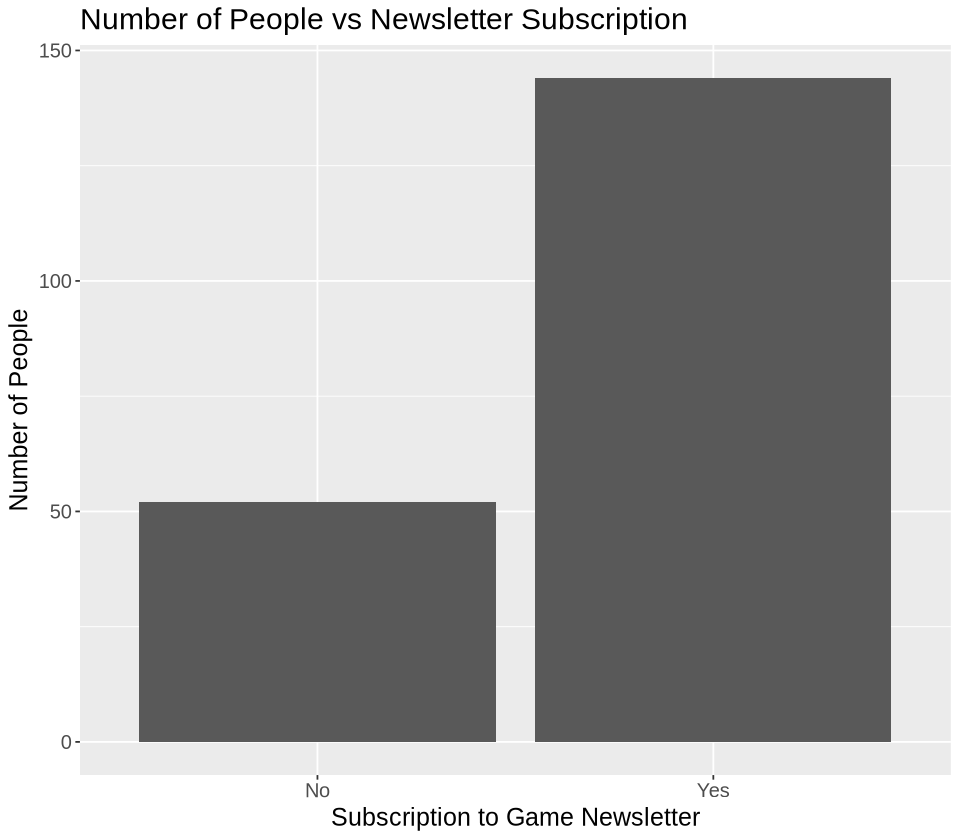

In [51]:
options(repr.plot.width = 8, repr.plot.height = 7) 

subcounts_plot <- playerdata |>
    group_by(subscribe) |>
    summarize(counts = n()) |>
    ggplot(aes(x = subscribe, y = counts)) +
    geom_bar(stat = "identity") +
    scale_x_discrete(labels = c("FALSE" = "No", "TRUE" = "Yes")) +
    labs(x = "Subscription to Game Newsletter", y = "Number of People") +
    theme(text = element_text(size = 15)) +
    ggtitle("Number of People vs Newsletter Subscription")

subcounts_plot

This visualization is relevant because it lets us know that there is a **class imbalance** in our response variable. The class imbalance will need to be addressed when building and training our predictive model for answering the specific question outlined earlier.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


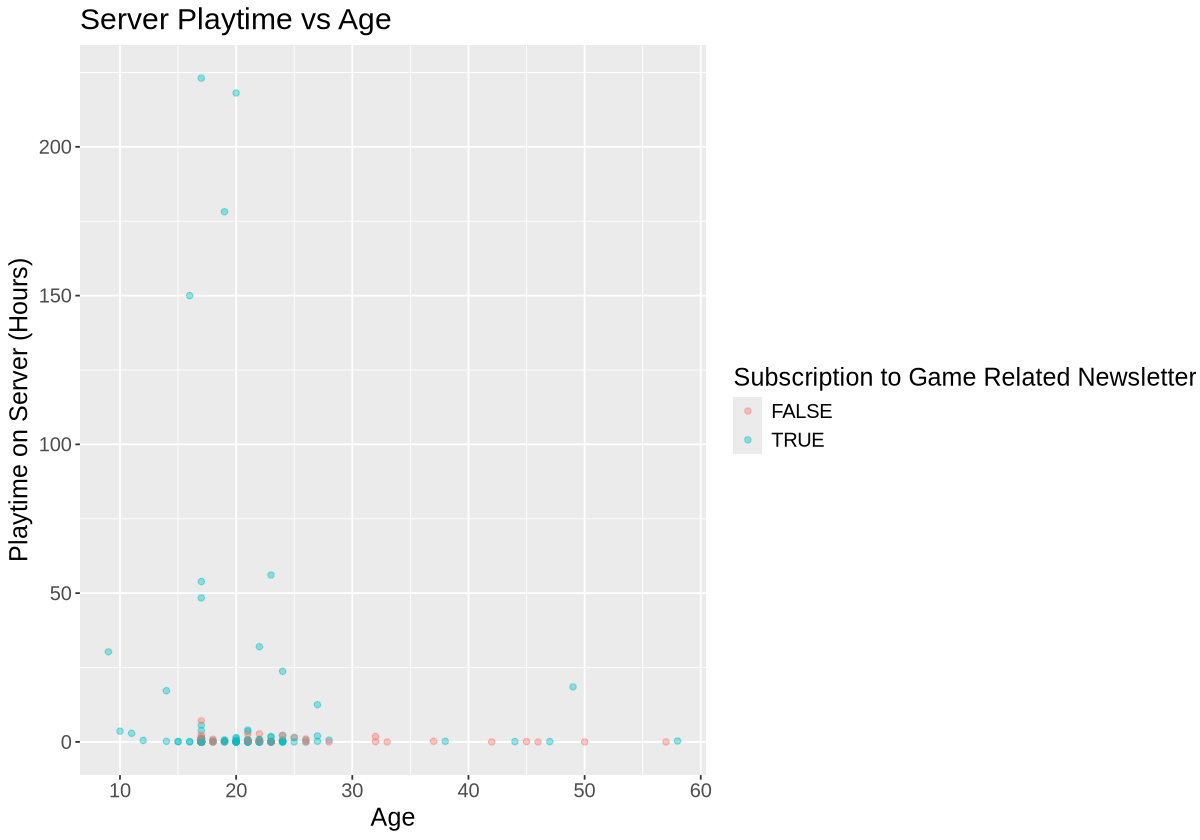

In [50]:
options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_hours_plot <- playerdata |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.4) +
    labs(x = "Age", y = "Playtime on Server (Hours)", color = "Subscription to Game Related Newsletter") +
    theme(text = element_text(size = 15)) +
    ggtitle("Server Playtime vs Age") +
    scale_fill_brewer(palette = 'Dark2')
age_vs_hours_plot

There is a significant difference in the scale of axises (more than 3x), suggesting that the variables might have to be normalized depending on the method that will be used to build a prediction model.

No obvious clusters or relationships can be observed from the plot in regards to subscription, which could mean that the two explanatory variables are not strong predictors.



## Methods and Plan

KNN-Classification is likely the best method to use to answer the question proposed. 

- Why?
    - The response variable (subscription to a game related newsletter) is a **class** variable with only 2 discrete values, TRUE/FALSE. KNN Classification's purpose is to predict for class variables given a set of predictors. Linear regression cannot be used because it predicts for numerical/quantifiable variables
- Which assumptions are required, if any, to apply the method selected?
    - KNN Classification makes very few assumptions, however it does work under the notion that points closer to one another share similar classes.
- What are the potential limitations or weaknesses of the method selected?
    -  It generally does not work well if there are class imbalances in the response variable, which is true for the given dataset. It can also be slow and computationally expensive if the dataset is large, however that should not apply here given the players.csv data is relatively small.
- How are you going to compare and select the model?
    - As mentioned previously, since the response variable is a categorical/class type variable, then only a classification model can be used. We can choose the model with the best accuracy by tuning it for different 'k' values. Ideally, the model should have a higher accuracy than the majority classifier (75%). 
- How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?
    - The explanatory variables will be centered and scaled first. After preprocessing, an initial split will be performed splitting the data into a training and testing set with a standard 0.75 proportion. The training set will then be split into 5 folds for cross validation, with one fold being the validation set.
